In [5]:
import pandas as pd
import os
import json

import pickle
from kg import KnowledgeGraph


# def create_nodes_pkl(data_dir):
#     """
#     Create node pickle file from KG node ensemble data.
    
#     Args:
#     	data_dir (str): Path of the data directory
#     """
#     nodes_df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/KG_node_map_ensembl_ids.txt', sep='\t', usecols=list(range(1, 7)))
    
#     pd.to_pickle(nodes_df, '{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl')


def add_node_indices(nodes_df, relations_df):
    """
    Add node indices from nodes dataframe to relations dataframe based on ID and type matching.
    
    Args:
    	nodes_df (pd.DataFrame): Dataframe containing node information with columns: node_idx, node_id, node_type
    	relations_df (pd.DataFrame): Dataframe containing relation information with columns: x_id, x_type, y_id, y_type
    
    Returns:
    	pd.DataFrame: Filtered relations dataframe with added x_idx, y_idx, and included columns
    """
    # Create a copy of the relations dataframe to avoid modifying the original
    result_df = relations_df.copy()
    
    # Convert node_id to string type in nodes_df for consistent matching
    nodes_df = nodes_df.copy()
    nodes_df['node_id'] = nodes_df['node_id'].astype(str)
    
    # Convert x_id and y_id to string type in relations_df
    result_df['x_id'] = result_df['x_id'].astype(str)
    result_df['y_id'] = result_df['y_id'].astype(str)
    
    # Create a mapping dictionary from (node_id, node_type) to node_idx
    node_mapping = pd.Series(
        nodes_df.node_idx.values,
        index=pd.MultiIndex.from_arrays([nodes_df.node_id, nodes_df.node_type])
    ).to_dict()
    
    # Create a function to safely get mapping value
    def get_mapping(row, id_col, type_col):
        key = (row[id_col], row[type_col])
        return node_mapping.get(key)
    
    # Add x_idx column by mapping (x_id, x_type)
    result_df['x_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'x_id', 'x_type'), 
        axis=1
    )
    
    # Add y_idx column by mapping (y_id, y_type)
    result_df['y_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'y_id', 'y_type'), 
        axis=1
    )
    
    # Check if both indices are valid (not NaN) and add 'included' column
    result_df['included'] = result_df['x_idx'].notna() & result_df['y_idx'].notna()
    
    # Filter rows where both x_idx and y_idx are not NaN
    result_df = result_df[result_df['included']].copy()
    
    # Convert x_idx and y_idx to integers
    result_df['x_idx'] = result_df['x_idx'].astype(int)
    result_df['y_idx'] = result_df['y_idx'].astype(int)
    
    return result_df


data_dir = os.environ.get('DATA_DIR', './Data')
output_dir = os.environ.get('OUTPUT_DIR', './Output')

df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')
print("Loading HPO to index dictionary...")

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/hpo_to_idx_dict_8.9.21_kg.pkl', 'rb') as f:
    hpo_to_idx_dict = pickle.load(f)

print("Loading Genes to index dictionary...")
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/ensembl_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    genes = pickle.load(file)

with open(f'{data_dir}/preprocess/orphanet/orphanet_to_mondo_dict.pkl', 'rb') as file:
        orphanet_to_mondo_dict = pickle.load(file)

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/mondo_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    mondo_to_idx_dict = pickle.load(file)

# create_nodes_pkl(data_dir)

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl', 'rb') as file:
    nodes = pickle.load(file)

/tmp/ipykernel_5375/13880158.py:82: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')


Loading HPO to index dictionary...
Loading Genes to index dictionary...


Loading nodes from ./Data/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl
Loaded 105,220 nodes
Node columns: ['node_idx', 'node_id', 'node_type', 'node_name', 'node_source', 'old_node_name']
Loading relationships from Output/result.csv
Processed 1 chunks (100,000 rows)
Current graph size: 105,220 nodes, 100,000 edges
Number of node types: 7


/media/kai/Kai_Backup/Study/GiG in rare diease detection/kg.py:588: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk_num, chunk in enumerate(pd.read_csv(filepath, chunksize=chunksize)):


Processed 11 chunks (1,100,000 rows)
Current graph size: 105,220 nodes, 1,095,378 edges
Number of node types: 7

Finished loading 1,100,000 relationship rows
Total nodes from pickle file: 105,220
Total unique node types: 7

=== Knowledge Graph Summary ===
Nodes: 105,220
Edges: 1,095,378
Density: 0.000198
Average Degree: 20.82
Connected Components: 56

Node Types Distribution:
  biological_process: 28,642
  cellular_component: 4,176
  disease: 21,233
  effect/phenotype: 15,874
  gene/protein: 21,610
  molecular_function: 11,169
  pathway: 2,516

Edge Types Distribution:
  bioprocess_bioprocess: 52,886
  cellcomp_cellcomp: 4,845
  disease_disease: 35,167
  disease_phenotype_negative: 1,483
  disease_phenotype_positive: 204,779
  disease_protein: 86,299
  molfunc_molfunc: 13,574
  pathway_pathway: 2,535
  phenotype_phenotype: 21,925
  phenotype_protein: 10,518
  protein_bioprocess: 144,805
  protein_cellcomp: 83,402
  protein_molfunc: 69,530
  protein_pathway: 42,646
  protein_protein: 32

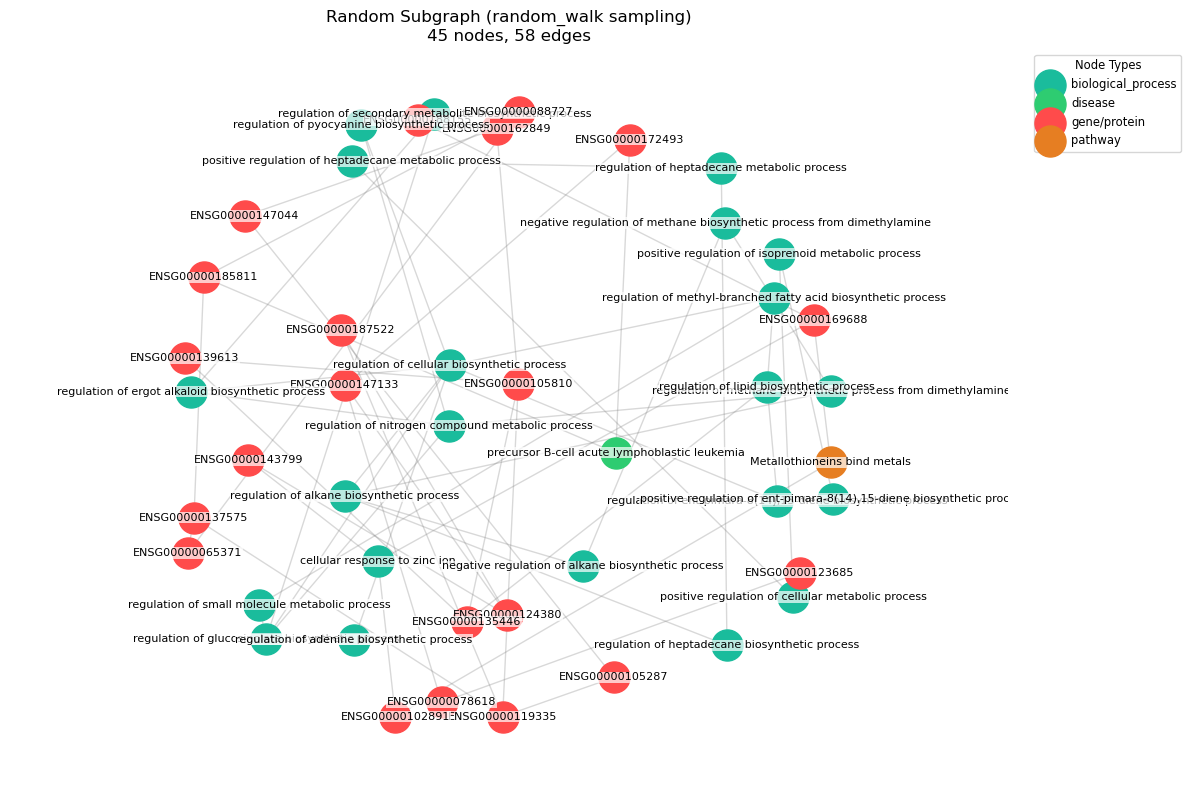

In [2]:
# Example usage
result = add_node_indices(nodes, df)
result.to_csv(f'{output_dir}/result.csv', index=False)

# # Initialize KG
kg = KnowledgeGraph()

# # Load data with chunks
kg.create_from_csv(
    filepath=f'./{output_dir}/result.csv',
    nodes_filepath = f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl',
    chunksize=100000,  # Adjust based on your memory constraints
    show_progress=True
)

# Save the graph
kg.save_graph(f'{output_dir}/my_graph_ids.graphml')


# code to double check the KG 
subgraph = kg.plot_random_subgraph(num_nodes=45, method='random_walk')

In [17]:
# # # Initialize KG
kg = KnowledgeGraph()
kg.load_graph(f'{output_dir}/my_graph_ids.graphml') #!!!!!!! if u want proper plotting u need to save and then load the graph, not work directly after creation the kg 

# WORKING with PATINIET DATA

print('Loading and processing patient data...')
file_path = f'{data_dir}/patients/simulated_patients/disease_split_val_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    val_data = [json.loads(line) for line in f]

file_path = f'{data_dir}/patients/simulated_patients/disease_split_train_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    train_data = [json.loads(line) for line in f]



val_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in val_data]
train_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in train_data]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(val_patients_phenotypes_list, f)

val_patients_genes = [
    [genes[g] for g in p['true_genes']]
    for p in val_data
]

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(train_patients_phenotypes_list, f)

train_patients_genes = [
    [genes[g] for g in p['true_genes']]
    for p in train_data
]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_genes.pkl', 'wb') as f:
    pickle.dump(val_patients_genes, f)

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_genes.pkl', 'wb') as f:
    pickle.dump(train_patients_genes, f)


val_all_candidate_genes = [
    [genes[g] for g in p['all_candidate_genes'] if g in genes]
    for p in val_data
]

# Save the list to a pickle file
with open(f'{output_dir}/val_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(val_all_candidate_genes, f)


train_all_candidate_genes = [
    [genes[g] for g in p['all_candidate_genes'] if g in genes]
    for p in train_data
]

# Save the list to a pickle file
with open(f'{output_dir}/train_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(train_all_candidate_genes, f)

print("Saved all preprocessed files regarding patient data.")

# add here the test data

Loading and processing patient data...
Saved all preprocessed files regarding patient data.


In [18]:
train_data[0]

{'true_genes': ['ENSG00000146085'],
 'age': 'Onset_Infant',
 'positive_phenotypes': ['HP:0000124',
  'HP:0001249',
  'HP:0001254',
  'HP:0001259',
  'HP:0001252',
  'HP:0001510',
  'HP:0002017',
  'HP:0004374',
  'HP:0410042',
  'HP:0001903',
  'HP:0100806',
  'HP:0001279',
  'HP:0000712',
  'HP:0100739',
  'HP:0031009',
  'HP:0001363',
  'HP:0001360'],
 'negative_phenotypes': {'HP:0000083': ['init_phenotypes'],
  'HP:0001019': ['phenotype_distractor.9'],
  'HP:0002716': ['phenotype_distractor.9'],
  'HP:0002240': ['phenotype_distractor.9'],
  'HP:0000643': ['noisy_phenotype'],
  'HP:0001369': ['noisy_phenotype'],
  'HP:0008226': ['noisy_phenotype']},
 'n_distractor_genes': 11,
 'distractor_genes': ['ENSG00000143727',
  'ENSG00000014216',
  'ENSG00000158352',
  'ENSG00000105664',
  'ENSG00000197915',
  'ENSG00000157766',
  'ENSG00000188994',
  'ENSG00000095464',
  'ENSG00000132155',
  'ENSG00000152457',
  'ENSG00000168056'],
 'dropout_phenotypes': {'positive_phenotypes': ['HP:0001733',

In [19]:
val_data[0]

{'true_genes': ['ENSG00000173801'],
 'age': 'Onset_Infant',
 'positive_phenotypes': ['HP:0000982',
  'HP:0004751',
  'HP:0010719',
  'HP:0000113',
  'HP:0001324',
  'HP:0001640',
  'HP:0003202',
  'HP:0000708',
  'HP:0011675',
  'HP:0001948',
  'HP:0000956',
  'HP:0001645',
  'HP:0200114',
  'HP:0005881',
  'HP:0025230',
  'HP:0003010',
  'HP:0000540'],
 'negative_phenotypes': {'HP:0009064': ['phenotype_distractor.6'],
  'HP:0003758': ['phenotype_distractor.6'],
  'HP:0100950': ['phenotype_distractor.10'],
  'HP:0009126': ['phenotype_distractor.12'],
  'HP:0001513': ['phenotype_distractor.12'],
  'HP:0002591': ['phenotype_distractor.12'],
  'HP:0001662': ['phenotype_distractor.17'],
  'HP:0100758': ['noisy_phenotype'],
  'HP:0000003': ['noisy_phenotype'],
  'HP:0004313': ['noisy_phenotype'],
  'HP:0011445': ['noisy_phenotype']},
 'n_distractor_genes': 20,
 'distractor_genes': ['ENSG00000115760',
  'ENSG00000082701',
  'ENSG00000185339',
  'ENSG00000116679',
  'ENSG00000133107',
  'ENSG

In [20]:
# Preprocces the test data

# File path to your text file
file_path = f'{data_dir}/patients/mygene2_patients/mygene2_5.7.22.txt'  # val data!!!!

with open(file_path, 'r') as f:
    test_data = [json.loads(line) for line in f]

In [21]:
test_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in test_data]


# Save the list to a pickle file
with open(f'{output_dir}/test_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(test_patients_phenotypes_list, f)

test_patients_genes = [
    [genes[g] for g in p['true_genes']]
    for p in test_data
]


# Save the list to a pickle file
with open(f'{output_dir}/test_patients_genes.pkl', 'wb') as f:
    pickle.dump(test_patients_genes, f)


test_all_candidate_genes = [
    [genes[g] for g in p['all_candidate_genes'] if g in genes]
    for p in test_data
]

# Save the list to a pickle file
with open(f'{output_dir}/test_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(test_all_candidate_genes, f)


print('Saved all preprocessed files regarding patient data.')

Saved all preprocessed files regarding patient data.


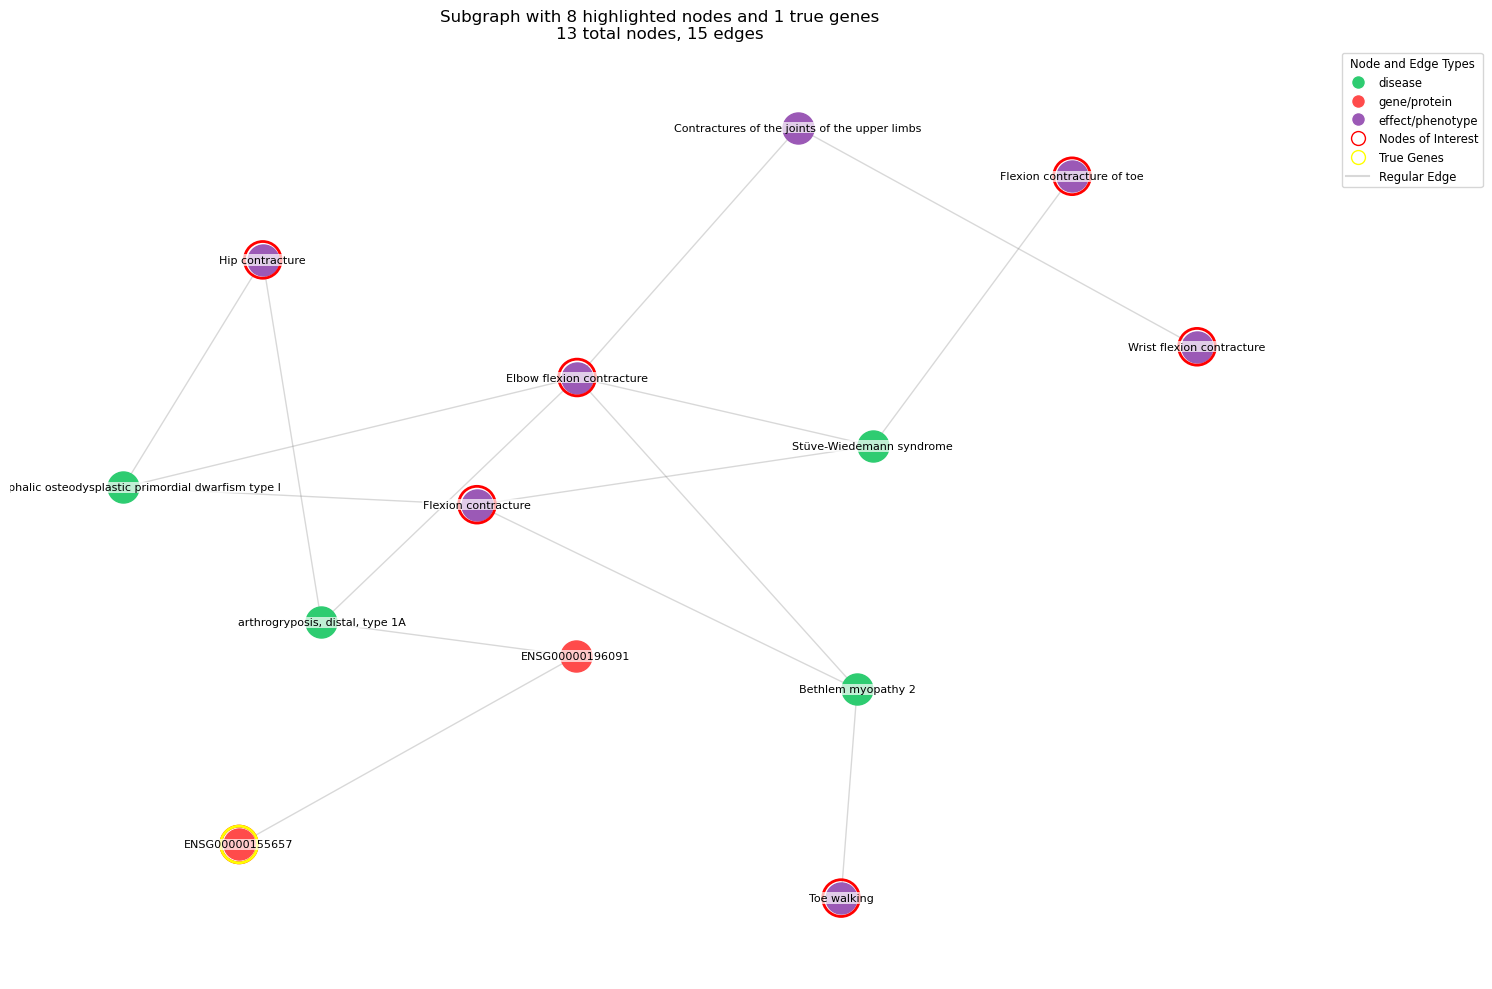

In [22]:
# plot the subgraph from val and from test
# check if the subgraphs are connected or not 

i=0

kg.visualize_subgraph([str(n) for n in test_patients_phenotypes_list[i] + test_all_candidate_genes[i] + test_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in test_patients_genes[i]])

In [23]:
train_nx_subgraph = []
train_pg_subgraph = []

for i in range(len(train_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in train_patients_phenotypes_list[i] + train_all_candidate_genes[i] + train_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in train_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    train_nx_subgraph.append(subgraph)
    train_pg_subgraph.append(pg_graph)

In [24]:
val_nx_subgraph = []
val_pg_subgraph = []

for i in range(len(val_patients_phenotypes_list)):

    # Without patients
    subgraph = kg.create_subgraph([str(n) for n in val_patients_phenotypes_list[i]+ val_all_candidate_genes[i]+ val_patients_genes[i]], true_gene_ids = [str(k) for k in val_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    val_nx_subgraph.append(subgraph)
    val_pg_subgraph.append(pg_graph)

In [25]:
test_nx_subgraph = []
test_pg_subgraph = []

for i in range(len(test_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in test_patients_phenotypes_list[i] + test_all_candidate_genes[i] + test_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in test_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    test_nx_subgraph.append(subgraph)
    test_pg_subgraph.append(pg_graph)

In [27]:
import torch
lookup = torch.nn.Embedding(num_nodes,dim=256) #105 200
emb = lookup(23)
add dataloader example 

pg_graph.x = lookup([pg_graph.node_mapping.key()])

x = encoder(pg_graph.x, pg_graph.edge_index)
x.shape = 14, dim

SyntaxError: invalid syntax (2064952324.py, line 4)

In [ ]:
pg_graph.true_gene_ids

[8190]

In [ ]:
pg_graph.node_mapping.key()

AttributeError: 'dict' object has no attribute 'key'

In [ ]:
pg_graph.edge_attr.shape

torch.Size([30, 15])

In [ ]:
pg_graph.edge_index.shape

torch.Size([2, 30])

In [ ]:
subgraph.nodes(data=True)

NodeDataView({'14498': {'type': 'effect/phenotype', 'name': 'Hypospadias', 'source': 'HPO'}, '15305': {'type': 'effect/phenotype', 'name': 'Hydrocephalus', 'source': 'HPO'}, '14016': {'type': 'effect/phenotype', 'name': 'Seizure', 'source': 'HPO'}, '8190': {'type': 'gene/protein', 'name': 'ENSG00000101871', 'source': 'NCBI'}, '20686': {'type': 'disease', 'name': 'skin creases, congenital symmetric circumferential, 2', 'source': 'MONDO'}, '14471': {'type': 'effect/phenotype', 'name': 'Nystagmus', 'source': 'HPO'}, '14594': {'type': 'effect/phenotype', 'name': 'Transient neonatal diabetes mellitus', 'source': 'HPO'}, '5339': {'type': 'gene/protein', 'name': 'ENSG00000113643', 'source': 'NCBI'}, '17902': {'type': 'effect/phenotype', 'name': 'Global developmental delay', 'source': 'HPO'}, '15075': {'type': 'effect/phenotype', 'name': 'Hypothyroidism', 'source': 'HPO'}, '213': {'type': 'gene/protein', 'name': 'ENSG00000254647', 'source': 'NCBI'}, '940': {'type': 'gene/protein', 'name': 'ENS

In [ ]:
import networkx as nx

# Assuming test_nx_subgraph is a list of graphs
subgraph = train_nx_subgraph[3]  # First subgraph

# Check if the graph is directed
is_directed = subgraph.is_directed()

# Check if the graph is connected
# For directed graphs, check strongly connected or weakly connected
if is_directed:
    is_connected = nx.is_strongly_connected(subgraph)  # Strongly connected
    is_weakly_connected = nx.is_weakly_connected(subgraph)  # Weakly connected
    print(f"Graph is directed: {is_directed}")
    print(f"Graph is strongly connected: {is_connected}")
    print(f"Graph is weakly connected: {is_weakly_connected}")
else:
    is_connected = nx.is_connected(subgraph)  # Connected (undirected case)
    print(f"Graph is directed: {is_directed}")
    print(f"Graph is connected: {is_connected}")

Graph is directed: False
Graph is connected: True


In [ ]:
# Create the output directory if it doesn't exist
output_folder = './Graph Outputs'
os.makedirs(output_folder, exist_ok=True)

# Combined lists to save
lists_to_save = {
    'val_nx_subgraph': val_nx_subgraph,
    'val_pg_subgraph': val_pg_subgraph,

    'train_nx_subgraph': train_nx_subgraph,
    'train_pg_subgraph': train_pg_subgraph,

    'test_nx_subgraph': test_nx_subgraph,
    'test_pg_subgraph': test_pg_subgraph,

}

# Save each list using pickle
for list_name, list_data in lists_to_save.items():
    file_path = os.path.join(output_folder, f'{list_name}.pkl')
    with open(file_path, 'wb') as file:
        pickle.dump(list_data, file)
    print(f'Saved {list_name} to {file_path}')

Saved val_nx_subgraph to ./Graph Outputs/val_nx_subgraph.pkl
Saved val_pg_subgraph to ./Graph Outputs/val_pg_subgraph.pkl
Saved train_nx_subgraph to ./Graph Outputs/train_nx_subgraph.pkl
Saved train_pg_subgraph to ./Graph Outputs/train_pg_subgraph.pkl
Saved test_nx_subgraph to ./Graph Outputs/test_nx_subgraph.pkl
Saved test_pg_subgraph to ./Graph Outputs/test_pg_subgraph.pkl


In [ ]:
import pickle

# Read the pickle file
with open('Output/train_patients_phenotypes_list.pkl', 'rb') as f:
    data = pickle.load(f)

# Examine the data
print("Type of data:", type(data))
print("\nFirst few elements:")
print(data[:5] if isinstance(data, list) else data)

# If it's a nested structure, examine deeper
if isinstance(data, list) and len(data) > 0 and isinstance(data[0], list):
    print("\nLength of first element:", len(data[0]))
    print("Sample from first element:", data[0][:5])

Type of data: <class 'list'>

First few elements:
[[14744, 15274, 14013, 14120, 14015, 14341, 15567, 15279, 15322, 14430, 19172, 14138, 60332, 69662, 19674, 16340, 15726], [60101, 14302, 17039, 14383, 15966, 15067, 16399, 17754, 15124, 15411, 16837, 14016, 14235, 14161, 14061, 14035, 60610, 15594, 60151, 16391], [15535, 14083, 14454, 14259, 14032, 60330, 66774, 67952, 15822], [14430, 15567, 69733, 69829, 16837, 14235, 18006, 14084, 16716, 15306, 14290, 14124], [60101, 60119, 14699, 60239, 17043, 15086, 60410, 15718, 16849, 14101, 14047, 14341, 15663, 14459, 17802, 68978, 63328, 14701, 63379, 15661, 60323, 18382, 60252, 14155, 14368, 15185, 63157, 69701, 15409, 14707, 64211]]

Length of first element: 17
Sample from first element: [14744, 15274, 14013, 14120, 14015]


Loading phenotype data...
Creating and visualizing patient network...

Network Statistics:
Number of patients shown: 50
Number of connections: 25

Top 5 strongest patient connections:
Patient 13 and Patient 29: 5 shared phenotypes
Patient 14 and Patient 19: 5 shared phenotypes
Patient 23 and Patient 36: 5 shared phenotypes
Patient 4 and Patient 46: 4 shared phenotypes
Patient 14 and Patient 33: 4 shared phenotypes


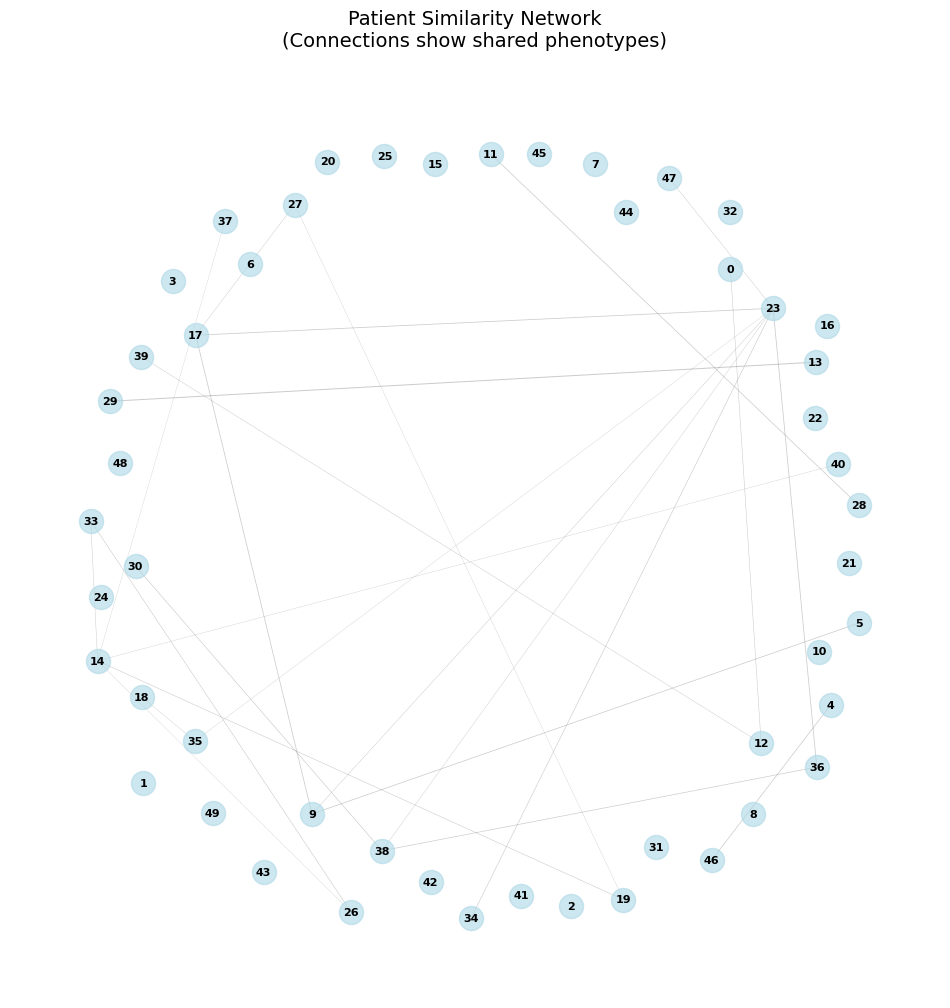

In [ ]:
# Load the phenotype data
with open('Output/train_patients_phenotypes_list.pkl', 'rb') as f:
    train_patients_phenotypes_list = pickle.load(f)

def create_patient_population_graph(phenotype_lists, sample_size=10000):
    """
    Create a smaller sample graph for better visualization
    """
    G = nx.Graph()
    
    # Take a sample of patients
    sample_indices = np.random.choice(len(phenotype_lists), sample_size, replace=False)
    sampled_phenotypes = [phenotype_lists[i] for i in sample_indices]
    
    # Add nodes
    for i in range(sample_size):
        G.add_node(i, phenotypes=set(sampled_phenotypes[i]))
    
    # Add edges
    for i in range(sample_size):
        phenotypes_i = set(sampled_phenotypes[i])
        for j in range(i+1, sample_size):
            phenotypes_j = set(sampled_phenotypes[j])
            
            shared = len(phenotypes_i.intersection(phenotypes_j))
            if shared >= 3:  # Only connect if they share at least 3 phenotypes
                jaccard = shared / len(phenotypes_i.union(phenotypes_j))
                G.add_edge(i, j, weight=jaccard, shared_count=shared)
    
    return G

def visualize_patient_graph(G):
    """
    Create a clear visualization of the patient network
    """
    plt.figure(figsize=(12, 12))
    
    # Use a layout that spreads nodes nicely
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color='lightblue',
                          node_size=300,
                          alpha=0.6)
    
    # Draw edges with varying thickness based on weight
    edge_weights = [G[u][v]['weight']*5 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos,
                          width=edge_weights,
                          alpha=0.4,
                          edge_color='gray')
    
    # Add node labels
    nx.draw_networkx_labels(G, pos,
                           font_size=8,
                           font_weight='bold')
    
    plt.title("Patient Similarity Network\n(Connections show shared phenotypes)", 
              fontsize=14, pad=20)
    plt.axis('off')
    return plt

# Create and visualize the graph
print("Creating and visualizing patient network...")
patient_pop_graph = create_patient_population_graph(train_patients_phenotypes_list)

# Print some statistics
print("\nNetwork Statistics:")
print(f"Number of patients shown: {patient_pop_graph.number_of_nodes()}")
print(f"Number of connections: {patient_pop_graph.number_of_edges()}")

# Find and print some interesting connections
edges = [(u, v, d['shared_count']) for u, v, d in patient_pop_graph.edges(data=True)]
if edges:
    top_connections = sorted(edges, key=lambda x: x[2], reverse=True)[:5]
    print("\nTop 5 strongest patient connections:")
    for p1, p2, shared in top_connections:
        print(f"Patient {p1} and Patient {p2}: {shared} shared phenotypes")

# Visualize
plt = visualize_patient_graph(patient_pop_graph)
plt.show()